## 11/7 Notebook to be converted to a script to run tests of mpasregions package

I think now is a good time to set up a simpler test grid as well as some units tests.
My recommendation would be a grid consisting of just 3 touching triangles or hexagons. (edited) 



In [345]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [346]:
#Packages 
import numpy as np
import xarray as xr
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import mpas_tools

from geometric_features import GeometricFeatures
from geometric_features import read_feature_collection

from mpas_tools.mesh.mask import compute_mpas_region_masks
from mpas_tools.parallel import create_pool
from mpas_tools.io import write_netcdf

import geojson
import json
import mosaic
import os.path
import mpasregions.sections as mps
import gsw
import warnings 
import glob
from xgcm import Grid

In [347]:
mesh_path = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
mesh = xr.open_dataset(mesh_path)
mesh = mesh.assign_coords({
"VertexID": xr.DataArray(mesh.indexToVertexID, dims=('nVertices',)),
})

In [348]:
lonCells = np.array([180.,  90., 270.])
latCells = np.array([-36.,  36.,  36.])

lonEdges = np.array([135., 235.,  90., 270.,  45., 135., 225., 315.,   0., 180., 45., 135., 225., 315.])
latEdges = np.array([-72., -72., -36., -36.,   0.,   0.,   0.,   0.,  36.,  36., 72.,  72.,  72.,  72.])

lonVertices = np.array([180.,  90., 270.,  90., 270.,   0., 180.,   0., 180., 90., 270.])
latVertices = np.array([-90., -54., -54., -18., -18.,  18.,  18.,  54.,  54., 90.,  90.])

ds = xr.Dataset({},coords={
    'nCells':xr.DataArray(np.arange(0,len(lonCells)), dims='nCells'),
    'nEdges': xr.DataArray(np.arange(0,len(lonEdges)), dims='nEdges'),
    'nVertices':xr.DataArray(np.arange(0,len(lonVertices)), dims='nVertices')
})

ds['lonCell'] = xr.DataArray(np.deg2rad(lonCells), dims='nCells')
ds['latCell'] = xr.DataArray(np.deg2rad(latCells), dims='nCells')
ds['lonEdge'] = xr.DataArray(np.deg2rad(lonEdges), dims='nEdges')
ds['latEdge'] = xr.DataArray(np.deg2rad(latEdges), dims='nEdges')
ds['lonVertex'] = xr.DataArray(np.deg2rad(lonVertices), dims='nVertices')
ds['latVertex'] = xr.DataArray(np.deg2rad(latVertices), dims='nVertices')

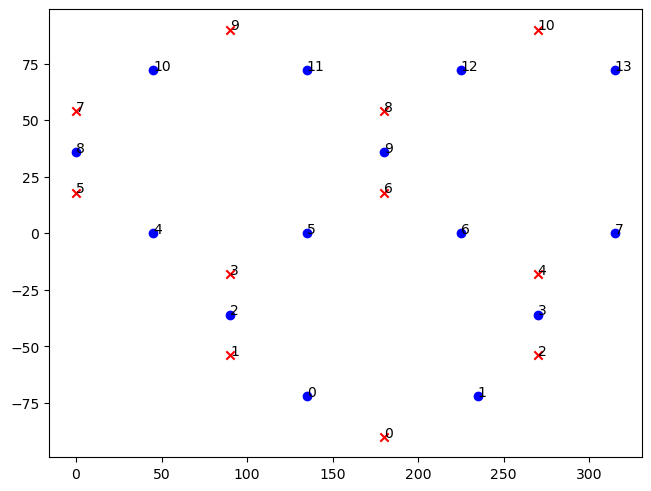

In [349]:
fig,ax=plt.subplots(nrows=1,ncols=1,constrained_layout=True)
ax.scatter(np.rad2deg(ds.lonEdge),np.rad2deg(ds.latEdge),color='blue')
ax.scatter(np.rad2deg(ds.lonVertex),np.rad2deg(ds.latVertex),marker='x',color='red')
nEdges = ds.nEdges.values
nVertices = ds.nVertices.values

for i, txt in enumerate(nEdges):
    ax.annotate(txt, (np.rad2deg(ds.lonEdge[i]),np.rad2deg(ds.latEdge[i])))

for i, txt in enumerate(nVertices):
    ax.annotate(txt, (np.rad2deg(ds.lonVertex[i]), np.rad2deg(ds.latVertex[i])))

In [350]:
xr_edgesOnVertex =  np.array([
    [0,1,np.nan], # on vertex 0
    [0,2,np.nan], # on vertex 1
    [1,3,np.nan], # on vertex 2
    [2,4,5], # on vertex 3
    [3,6,7], # on vertex 4
    [4,7,8], # on vertex 5
    [5,6,9], # on vertex 6
    [8,10,13], # on vertex 7
    [9,11,12], # on vertex 8
    [10,11,np.nan], # on vertex 9
    [12,13,np.nan] # on vertex 10
])

n_edgesOnVertex = mps.xr_to_n_idx(xr_edgesOnVertex)
n_edgesOnVertex[np.isnan(n_edgesOnVertex)] = 0 # extra vertices that were once nans are now zeros

ds['edgesOnVertex'] = xr.DataArray(np.int32(n_edgesOnVertex), dims = ('nVertices','vertexDegree'))
# ds['edgesOnVertex'] = ds.edgesOnVertex.where(ds.edgesOnVertex > 0)
# ds.edgesOnVertex

In [351]:
xr_verticesOnEdge = np.array([
    [0,1], # on edge 0
    [0,2], # on edge 1
    [1,3], # on edge 2
    [2,4], # on edge 3
    [3,5], # on edge 4
    [3,6], # on edge 5
    [4,6], # on edge 6
    [4,5], # on edge 7
    [5,7], # on edge 8
    [6,8], # on edge 9
    [7,9], # on edge 10
    [8,9], # on edge 11
    [8,10], # on edge 12
    [7,10] # on edge 13
    
])

n_verticesOnEdge = mps.xr_to_n_idx(xr_verticesOnEdge)
ds['verticesOnEdge'] = xr.DataArray(np.int32(n_verticesOnEdge), dims=('nEdges', 'TWO'))

In [352]:
ds['VertexID'] = mps.xr_to_n_idx(ds.nVertices)
ds = ds.assign_coords({'VertexID': mps.xr_to_n_idx(ds.nVertices)})

In [353]:
target_start_lon, target_start_lat = 0, 18
target_end_lon, target_end_lat = 180, 18

In [391]:
# **** TEST TRANSECT CALCULATION ALGORTHMS ****

# I acutally don't really know how to generalize this so that we don't require building a transect through specific points? 

# test if basic algorithm works
def test_calculate_transects(ds):
    from mpasregions.sections import calculate_transects
    # test if basic algorithm works
    target_start_lon, target_start_lat = 90, -30
    target_end_lon, target_end_lat = 180, 60
    test_edges, test_vertices = calculate_transects(target_start_lat, target_start_lon, target_end_lat, target_end_lon, ds)
    assert (test_vertices == np.array([3,6,8])).all()
    assert(test_edges == np.array([5,9])).all()

    # test periodicity in x-direction
    target_start_lon, target_start_lat = 0, 18
    target_end_lon, target_end_lat = 270, 18
    test_edges, test_vertices = calculate_transects(target_start_lat, target_start_lon, target_end_lat, target_end_lon, ds)
    assert (test_vertices == np.array([5,4])).all()
    assert(test_edges == 7)

    # test periodicity in y-direction
        # the transect should move south to north (90,-54) does not connect to (90,54) directly.
    target_start_lon, target_start_lat = 90, -54
    target_end_lon, target_end_lat = 90, 90
    test_edges, test_vertices = calculate_transects(target_start_lat, target_start_lon, target_end_lat, target_end_lon, ds)
    assert(test_vertices == np.array([1,3,5,7,9])).all()
    assert(test_edges == np.array([2,4,8,10])).all()

def test_calculate_transects_multiple_pts(ds):
    from mpasregions.sections import calculate_transects_multiple_pts
    # calculate_transects_multiple_pts(segment_lons,segment_lats,ds)

    # test if basic algorithm works
    target_lons = np.array([90,90,180])
    target_lats = np.array([-18,90,18])
    test_edges, test_vertices = calculate_transects_multiple_pts(target_lons, target_lats, ds)
    assert(test_vertices == np.array([3,5,7,9,8,6])).all()
    assert(test_edges == np.array([4,8,10,11,9,5])).all()

    # test periodicity in x-direction
    target_lons = np.array([270,360,180]) 
    target_lats = np.array([0,0,0])
    test_edges, test_vertices = mps.calculate_transects_multiple_pts(target_lons, target_lats, ds)
    assert(test_vertices == np.array([4,5,3,6])).all()
    assert(test_edges == np.array([7,4,5,6])).all()

    # test periodicity in y-direction
    target_lons = np.array([90,180,270])
    target_lats = np.array([-54,-90,90])
    test_edges, test_vertices = mps.calculate_transects_multiple_pts(target_lons, target_lats, ds)
    assert(test_vertices == np.array([1,0,1,3,5,7,10,7,5,3])).all()

In [ ]:
# **** TEST TRANSECT SORTING ALGORTHMS ****
def test_sorted_transect_edges_and_vertices(ds):
    from mpasregions.sections import sorted_transect_edges_and_vertices
    

In [384]:
def test_calcs(ds):
    target_lons = np.array([90,180,270])
    target_lats = np.array([-54,-90,90])
    test_edges, test_vertices = mps.calculate_transects_multiple_pts(target_lons, target_lats, ds)
    return test_edges,test_vertices, target_start_lon, target_end_lon, target_start_lat, target_end_lat

In [385]:
test_edges, test_vertices,target_start_lon, target_end_lon, target_start_lat, target_end_lat = test_calcs(ds)

1
possible vertices to move to are  [0 1 3]
the chosen next vertex to move to is  0
broken because reached end vertex
0
possible vertices to move to are  [0 1 2]
the chosen next vertex to move to is  1
1
possible vertices to move to are  [0 1 3]
the chosen next vertex to move to is  3
3
possible vertices to move to are  [1 3 5 6]
the chosen next vertex to move to is  5
5
possible vertices to move to are  [3 4 5 7]
the chosen next vertex to move to is  7
7
possible vertices to move to are  [ 5  7  9 10]
the chosen next vertex to move to is  10
broken because reached end vertex
10
possible vertices to move to are  [ 7  8 10]
the chosen next vertex to move to is  7
7
possible vertices to move to are  [ 5  7  9 10]
the chosen next vertex to move to is  5
5
possible vertices to move to are  [3 4 5 7]
the chosen next vertex to move to is  3
3
possible vertices to move to are  [1 3 5 6]
the chosen next vertex to move to is  1
broken because reached end vertex


In [386]:
test_edges

array([-1.,  0., -1.,  0.,  2.,  4.,  8., 13., 13.,  8.,  4.,  2.])

In [390]:
test_vertices

array([ 1.,  0.,  1.,  3.,  5.,  7., 10.,  7.,  5.,  3.])

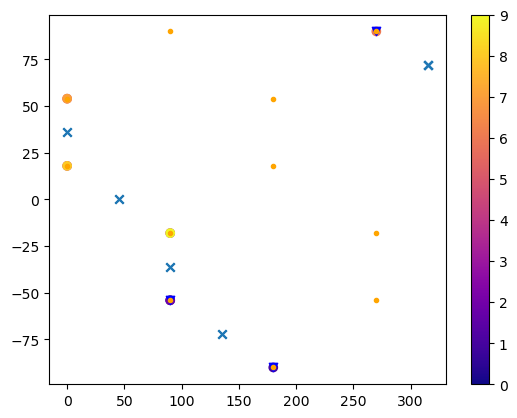

In [388]:
fig, ax = plt.subplots(nrows=1, ncols=1)

target_lons = np.array([90,180,270])
target_lats = np.array([-54,-90,90])

nv_lons_deg = np.rad2deg(ds.lonVertex.isel(nVertices = np.int32(test_vertices)))
nv_lats_deg = np.rad2deg(ds.latVertex.isel(nVertices = np.int32(test_vertices)))

a = ax.scatter(nv_lons_deg, nv_lats_deg, label = 'calculate_transects', c=np.arange(0,len(nv_lats_deg)), cmap = 'plasma')

ax.scatter(target_lons,target_lats, label='target start and end',color='blue',marker='v')

ax.scatter(np.rad2deg(ds.lonVertex), np.rad2deg(ds.latVertex), marker='.', label = 'Vertex points',color='orange')

ne_lons_deg = np.rad2deg(ds.lonEdge.isel(nEdges = np.int32(test_edges)))
ne_lats_deg = np.rad2deg(ds.latEdge.isel(nEdges = np.int32(test_edges)))

ax.scatter(ne_lons_deg, ne_lats_deg, marker = 'x')
#ax.legend()
fig.colorbar(a)